# TP - Non-parametric regression (Cubic splines)
<h4 align="right"> Author: Hicham Janati </h4>

The motorcycle dataset records the head's acceleration after an accident as a function of time. Download and visualize the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/hichamjanati/hichamjanati.github.io/master/_data/Motorcycledata.txt"
names = ["x", "y"]
df_raw = pd.read_csv(url, index_col=0, delim_whitespace=True, names=names)
print(df_raw.shape)
df_raw.head()

(133, 2)


,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


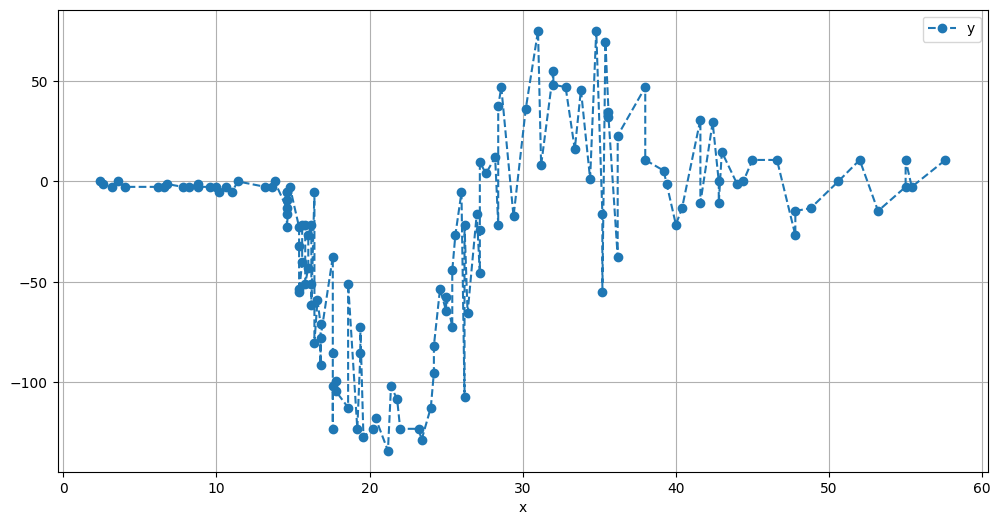

In [2]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
ax.grid()

#### Question 1
Transform the data to variables $(x, y, w)$ such that duplicated values are handled and ready to be fed to a weighted spline regression (cf TD Questions 5-6). 

In [3]:
w = df_raw.groupby('x').size().values
W = np.diag(w)
x, y = df_raw.groupby('x', as_index=False).mean().values.T

### Polynomial regression
Polynomial regression (fitting a best polynomial on the data) can be done using `np.polyfit` to obtain the coefficients and `polyval` to evaluate it.

#### Question 2
Perform (weighted) polynomial regression on the data and visualize the fitted curves for degrees 1, 3, 10 on the same plot. Try higher degree polynomial fits. Besides overfitting, why is this potentially a bad idea ?

En plus de l'overfitting, interpoler avec un polynome de haut degré implique un long temps de calcul. En revanche, interpoler avec un polynome de trop bas degré implique de l'underfitting malgré un temps de calcul court.

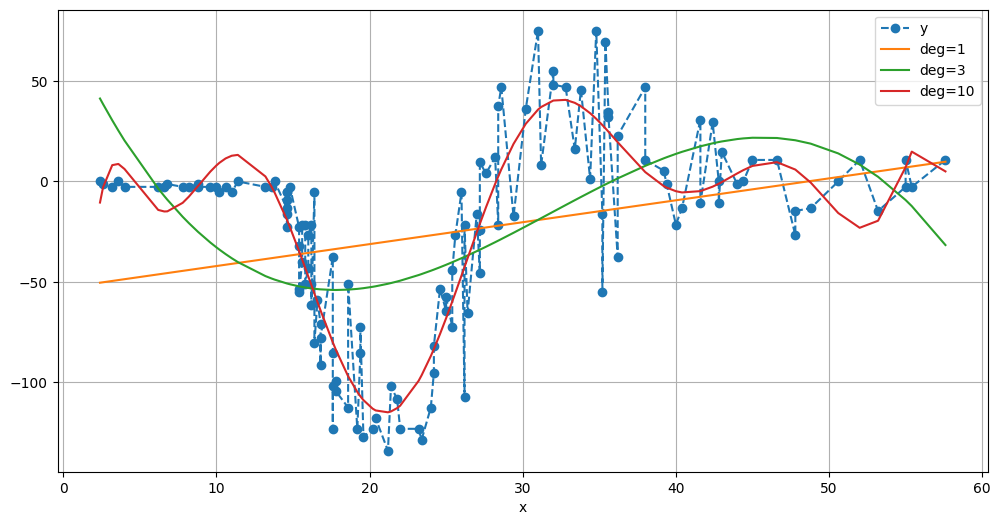

In [4]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))

deg = 1
coefs = np.polyfit(x, y, deg=deg, w=w**0.5)
ax.plot(x, np.polyval(coefs, x), label='deg=1')

deg = 3
coefs = np.polyfit(x, y, deg=deg, w=w**0.5)
ax.plot(x, np.polyval(coefs, x), label='deg=3')

deg = 10
coefs = np.polyfit(x, y, deg=deg, w=w**0.5)
ax.plot(x, np.polyval(coefs, x), label='deg=10')

ax.grid()
ax.legend()
plt.show()

## Cubic spline regression
#### Question 3
Complete the function `solve_splines_naive` that computes $g$ and $\gamma$ given the data. 

#### Question 4 
Knowing that $R + \alpha Q^\top Q$ is invertible, write an implementation of `solve_splines` that performs 0 matrix inversions.

We think there is a little mistake and we can use the invertibility of the matrix $R + \alpha Q^\top W^{-1} Q$. With some manipulation we get $(R + \alpha Q^\top W^{-1} Q)\gamma = Q^\top Y$. So we can use the LU decomposition to get   $(R + \alpha Q^\top W^{-1} Q) = L U$ where L is lower triangular  and U is upper triangular. Then we can solve succesively $L\Gamma = Q^\top Y$ and $U\gamma = \Gamma$ without matrix inversion. We'll use lu_solve from scipy that performs that. 

In [5]:
from scipy.linalg import lu_factor, lu_solve

def _construct_R_Q(x):
    """Function that constructs the matrices R and Q given the knots x_i."""
    n = len(x)
    h = np.diff(x)
    R = np.zeros((n-2, n-2))
    Q = np.zeros((n, n))
    
    # construct R
    indx = np.arange(n)
    # diag elements
    R[indx[:-2], indx[:-2]] = (h[1:] + h[:-1]) / 3
    # upper + lower diag elements
    R[indx[:-3], indx[1:-2]] = R[indx[1:-2], indx[:-3]] = h[1:-1] / 6
    
    # construct Q with the weird column indexing in mind in (n x n) matrix before filtering at the end
    Q[indx[1:-1], indx[1:-1]] = - 1 / h[1:] - 1 / h[:-1]
    Q[indx[2:], indx[1:-1]] = 1 / h[:-1]
    Q[indx[:-2], indx[1:-1]] = 1 / h[1:]
    
    # keep the n x n-2 matrix 
    Q = Q[:, 1:-1]

    return R, Q

def solve_splines_naive(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    R, Q = _construct_R_Q(x)

    Ri = np.linalg.inv(R)
    K = Q @ Ri @ Q.T
    W = np.diag(weights)

    A = W + alpha * K
    g = np.linalg.solve(A, W @ y)
    gamma = Ri @ Q.T @ g

    return g, gamma


def solve_splines(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""

    # Get the second member of the equation
    R, Q = _construct_R_Q(x)
    qtg = Q.T @ y

    # Perform LU decomposition
    Wi = np.diag(1 / weights)
    lu, piv = lu_factor(R + alpha * Q.T @ Wi @ Q)
    
    # Get gamma by solving two system with lu_solve to avoid matrix inversion
    gamma = lu_solve((lu, piv), qtg)

    # Get g
    g = y - alpha * Wi @ Q @ gamma

    return g, gamma

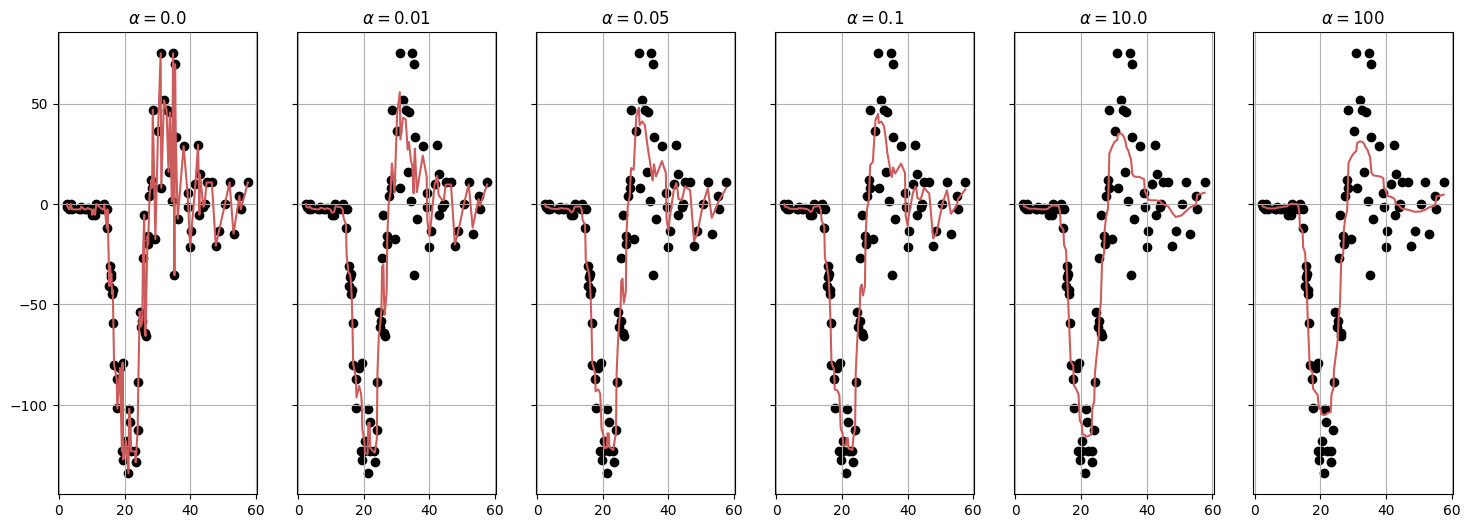

In [6]:
# With matrix inversion

alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines_naive(x, y, w, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

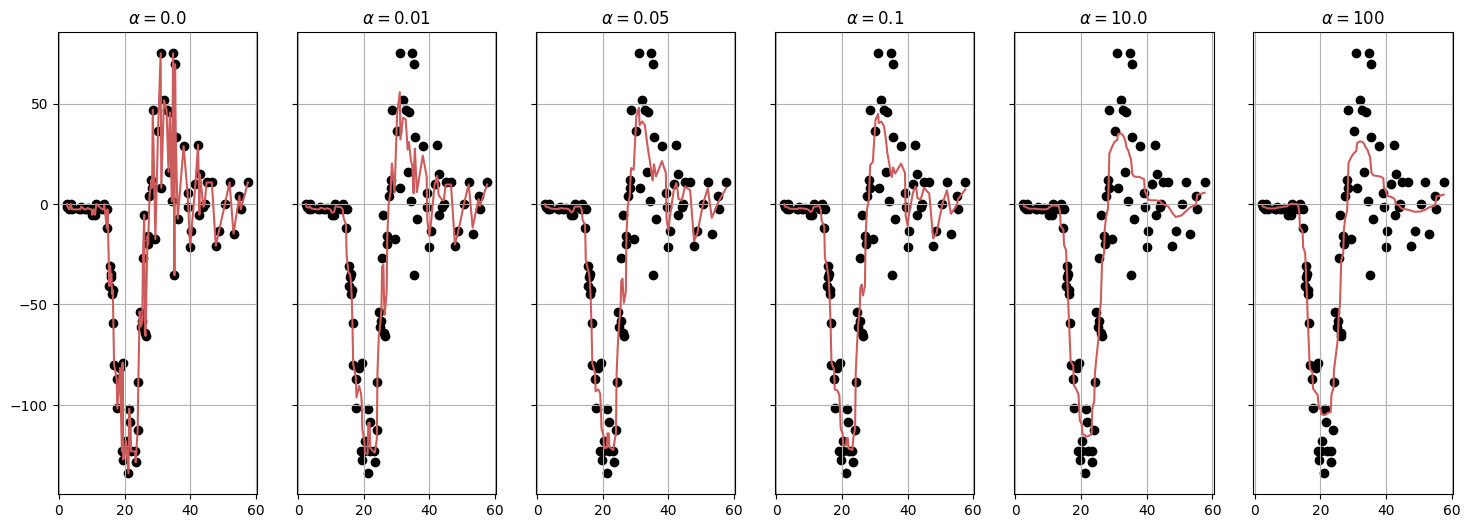

In [7]:
# Without matrix inversion

alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines(x, y, w, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

We indeed find that the splines overfit with small alpha and underfit with large alpha.

#### Question 5
Implement a GCV function that returns the GCV score. Visualize the GCV score as a function of alpha.

In [8]:
def gcv(x, y, weights, alphas):
    """Compute GCV score for a grid of alphas"""

    gcv_alpha = np.empty(len(alphas))

    R, Q = _construct_R_Q(x)

    W = np.diag(weights)
    Ri = np.linalg.inv(R)
    K = Q @ Ri @ Q.T

    eig, _ = np.linalg.eig(K)

    for i, alpha in enumerate(alphas):

      tr = (1 / (1 + alpha*eig)).sum()

      A = W + alpha * K
      g = np.linalg.solve(A, W @ y)
      gcv_alpha[i] = ((y - g)**2).sum() / (1 - tr / len(y))**2

    return gcv_alpha

In [9]:
gcv(x, y, w, np.array([1, 2, 5, 6, 1, 0.001]))

array([ 47928.45715965,  46123.37591724,  44250.84725   ,  43959.57631468,
        47928.45715965, 126091.58532804])

The best gcv is obtained with α = 57.223676593502205


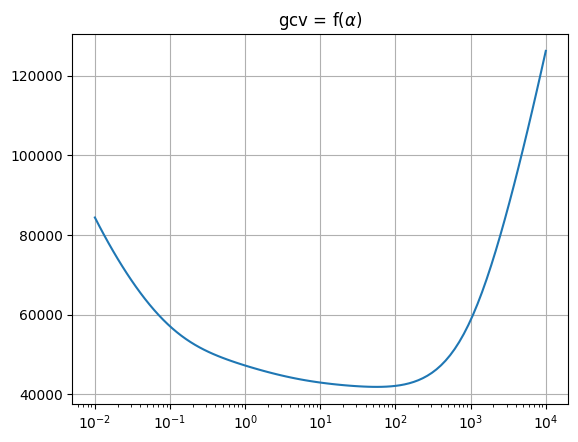

In [10]:
alphas = np.logspace(-2, 4, 100)
gcv_alphas = gcv(x, y, w ** 0.5, alphas)
plt.plot(alphas, gcv_alphas)
plt.xscale('log')
plt.grid()
plt.title(rf"gcv = f($\alpha$)")
print(rf'The best gcv is obtained with α = {alphas[np.argmin(gcv_alphas)]}')

### Custom regressor and cross validation with scikit-learn
To evaluate the best polynomial fit using cross-validation, we write our own scikit-learn and use scikit-learn's GridSearchCV to perform cross-validation. 

#### Question 6
Fill the class below and find the best Polynomial fit:


In [11]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, LeaveOneOut

class PolynomialFit(BaseEstimator, RegressorMixin):
    def __init__(self, degree=5):
        self.degree = degree
        
    def fit(self, x, y, weights=None):
        self.coefs = np.polyfit(x, y, deg=self.degree, w=weights)
        return self

    def predict(self, x):
        return np.polyval(self.coefs, x)

    def score(self, x, y):
      y_pred = self.predict(x)
      return -np.mean((y_pred - y)**2) #-mse

params = {"degree": np.arange(16)}

cv = LeaveOneOut()
poly_cv = GridSearchCV(PolynomialFit(), params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x, y, weights=w ** 0.5)
poly_cv.best_estimator_

PolynomialFit(degree=15)

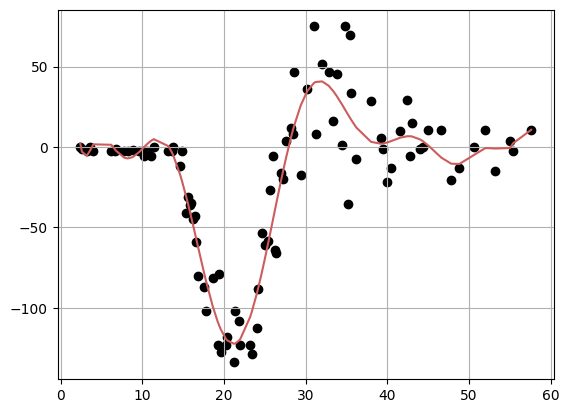

In [12]:
# Plot the best estimator
y_pred = poly_cv.best_estimator_.predict(x)
plt.scatter(x, y, color="k")
plt.grid()
plt.plot(x, y_pred, color="indianred")
plt.show()

#### Question 7
See the content of `poly_cv.cv_results_` and plot the mean CV score as a function of the degree. 

the best mean test score is obtained with the degree = 16


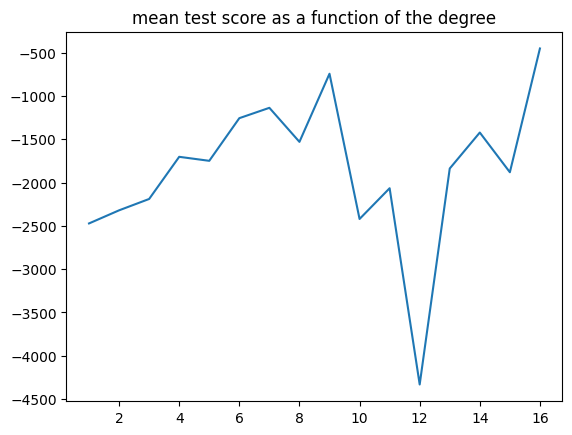

In [13]:
mean_test_score = poly_cv.cv_results_['mean_test_score']
degrees = range(1, len(mean_test_score) + 1)
plt.plot(degrees, mean_test_score)
plt.title(rf'mean test score as a function of the degree')
print(rf'the best mean test score is obtained with the degree = {degrees[np.argmax(mean_test_score)]}')

#### Question 8
Visualize the obtained best polynomial fit as well as the best cubic spline given by the GCV score minimizer.

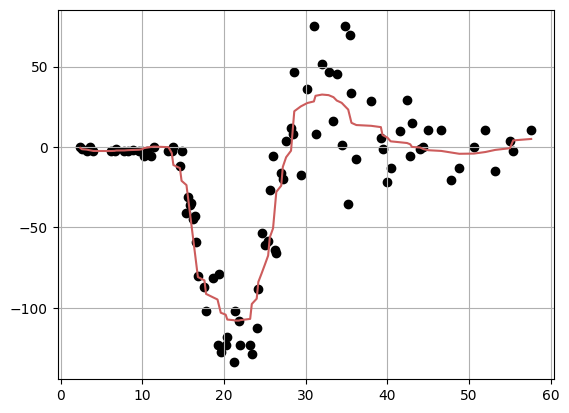

In [14]:
# Best spline 

best_alpha = alphas[np.argmin(gcv_alphas)]
g, gamma = solve_splines(x, y, w, alpha=best_alpha)
plt.scatter(x, y, color="k")
plt.grid()
plt.plot(x, g, color="indianred")

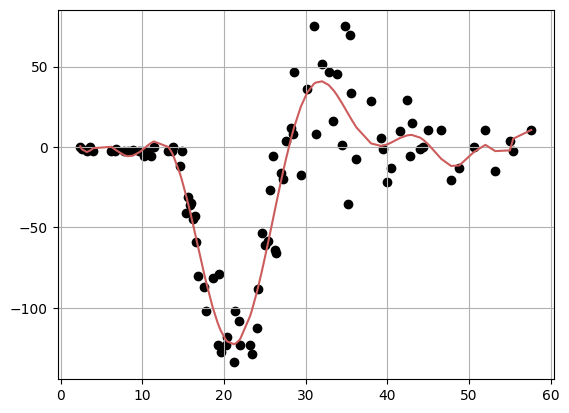

In [15]:
# Best polynomial fit

best_degree = degrees[np.argmax(mean_test_score)]
poly_pred = PolynomialFit(best_degree).fit(x, y, w ** 0.5).predict(x)
plt.scatter(x, y, color="k")
plt.grid()
plt.plot(x, poly_pred, color="indianred")
plt.show()

The cubic spline is a better approximation, but the polynomial regression seems smoother.

#### Question 9
Scikit-learn pipelines can be used to serialize several operations or models in one estimator. For ex:
```from sklearn.pipeline import Pipeline
pip = Pipeline([("Model_1_Name", Model1), ("Model_2_Name", Model2)])
pip.fit(X, y) ....
```
Using scikit-learn's `PolynomialFeatures` transformator, write a model that performs a polynomial.

Because x is a 1-dimensional array, PolynomialFeatures construct from x a matrix X with $x, x^2, ..., x^k$. So it's the matrix of data with k features ($x, x^2, ..., x^k$). Then performing a linear regression on this matrix X will find the best relation between the features. In this case, it will find the best relation between $x, x^2, ..., x^k$ that is exactly the polynomial regression.

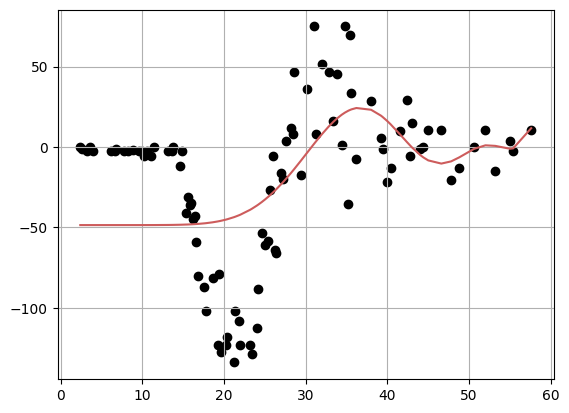

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

deg = 16

pipe = Pipeline([('polynomialfeature', PolynomialFeatures(degree=deg)), ('linreg', LinearRegression())])
pipe.fit(x.reshape(-1, 1), y, linreg__sample_weight=w)
y_pred = pipe.predict(x.reshape(-1, 1))

# Plot
plt.scatter(x, y, color="k")
plt.plot(x, y_pred, color="indianred")
plt.grid()
plt.show()

We don't find the same result than before and we don't know why.

#### Question 10
Perform cross validation on the degree of this model using scikit-learn.

We use GridSearchCV to search for the best parameters. 

The best estimator is obtained with the degree=8


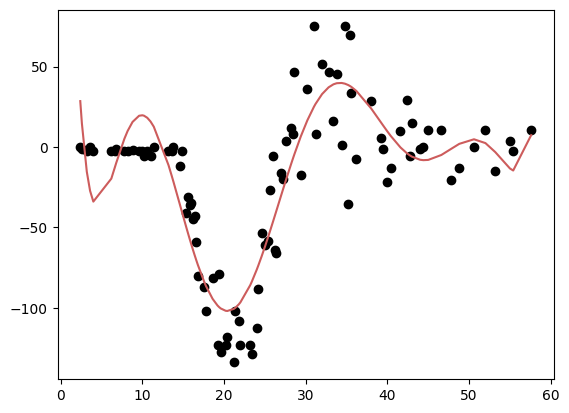

In [96]:
# We search for the best parameter
cv = LeaveOneOut()
params ={'polynomialfeature__degree': range(1, 17)}
model = Pipeline([('polynomialfeature', PolynomialFeatures()), ('linreg', LinearRegression())])
poly_cv = GridSearchCV(model, params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x.reshape(-1, 1), y)
print(f'The best estimator is obtained with the degree={poly_cv.best_params_["polynomialfeature__degree"]}')

# Best parameter
deg = poly_cv.best_params_["polynomialfeature__degree"]

# We compute the 
pipe = Pipeline([('polynomialfeature', PolynomialFeatures(degree=deg)), ('linreg', LinearRegression())])
pipe.fit(x.reshape(-1, 1), y)
y_pred = pipe.predict(x.reshape(-1, 1))
plt.scatter(x, y, color="k", label='raw data')
plt.plot(x, y_pred, color="indianred", label='Polynomial regression')
plt.show()

#### Question 11
Find the analytical expression of the NCS given $g$ and $\gamma$ to evaluate it on any data point $x$. Visualize it on a grid of a few hundred regular points.

We have to determine the function g between each points. Between $x_i$ and $x_{i+1}$ we can write $g(x) = ax^3 + bx^2 + cx + d$ and $ γ(x) = 6ax + 2b $. And the problem is to get a, b, c, d knowing $g(x_i), g(x_{i+1}), \gamma(x_i), γ(x_{i+1})$. It's an easy problem since we get four equations for four unknown variables. If $x = (x_0, ..., x_{n-1})$, γ is defined for $i=1, ..., n-2$. But because the NCS is linear outside $[x_0, x_{n-1}]$ (we can take it constant), we can extend gamma with $γ(x_0) = \gamma(x_{n-1}) = 0$. The system to solve is 


\begin{align*}
&\begin{cases}
a x_i^3 + b x_i^2 + c x_i + d = g(x_i) \\
6 a x_i + 2 b = \gamma(x_i) \\
a x_{i+1}^3 + b x_{i+1}^2 + c x_{i+1} + d = g(x_{i+1}) \\
6 a x_{i+1} + 2 b = \gamma(x_{i+1}) \
\end{cases}\
\end{align*}

To compute that, we decide to get one for all the parameters of the function g between each group of two points and then to apply on the grid. This will be in $𝑂(n)$ rather than in $𝑂(k)$ where k is the number of points in the grid to evaluate.

In [91]:
def get_params(x, g, gamma):

  # We extend gamma
  gamma_extended = np.zeros(len(gamma) + 2)
  gamma_extended[1:-1] = gamma

  # Return a numpy array st G[i] = [a, b, c, d] for x between x_i and x_i+1
  n = len(gamma_extended)
  G = np.zeros((n-1, 4))

  for i in range(n-1):

    gamma_i = gamma_extended[i]
    gamma_i1 = gamma_extended[i+1]
    g_i = g[i]
    g_i1 = g[i+1]
    x_i = x[i]
    x_i1 = x[i+1]

    # We create the system to solve
    b = np.array([g_i, g_i1, gamma_i, gamma_i1])
    A = np.array([[x_i**3, x_i**2, x_i, 1],
                  [x_i1**3, x_i1**2, x_i1, 1],
                  [6*x_i, 2, 0, 0],
                  [6*x_i1, 2, 0, 0]])
    
    param = np.linalg.solve(A, b)
    
    G[i] = param
  
  return G

params = get_params(x, g, gamma)

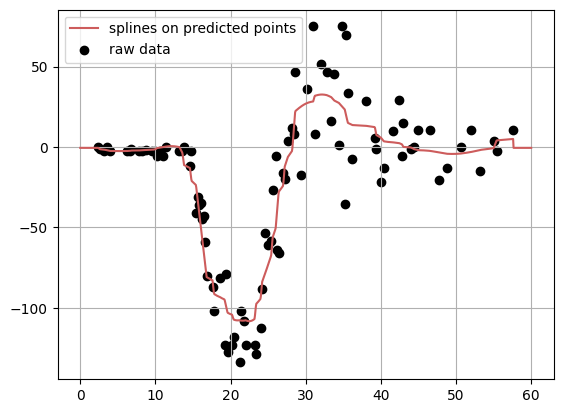

In [92]:
def get_gx(t, g=g, x=x, params=params):

  # We search where the point t goes in the list x
  i = np.argmax((x - t) > 0) 

  # If the point is outside [x_0, x_{n-1}] we return the extreme value (function constant outside)
  if i == 0:
    return g[0]
  if i == len(x):
    return g[-1]

  # Else we get the parameters of the splines and we return the image of the function
  a, b, c, d = params[i-1]
  return a*(t**3) + b*(t**2) + c*t + d

t = np.linspace(0, 60, 1000)
s = np.vectorize(get_gx)(t)
plt.plot(t, s, label='splines on predicted points', c='indianred')
plt.scatter(x, y, label='raw data', c='black')
plt.legend()
plt.grid()
plt.show()